In [88]:
import pandas as pd
from math import radians, sin, cos, sqrt, asin

# Cargar archivos
ventas_df = pd.read_csv("ventas.csv")
abonos_df = pd.read_csv("abonos.csv")
# Normalizar columnas
ventas_df.columns = ventas_df.columns.str.strip().str.lower()
abonos_df.columns = abonos_df.columns.str.strip().str.lower()


In [89]:
# Definir porcentajes de abono en efectivo por cartera
porcentajes_abono_efectivo = {
    'TIEMPO AIRE': 0.9717,
    'ROPA': 0.5729,
    'MUEBLES': 0.27
    #'PRESTAMOS': 0.0
}

In [90]:
# --- VENTAS ---

# Ventas en efectivo: contado
ventas_df['ventas_efectivo'] = ventas_df.apply(
    lambda row: row['promedio_venta'] if row['tipocompra'].lower() in ['contado'] else 0,
    axis=1
)

# Ventas electrónicas: crédito
ventas_df['ventas_electronico'] = ventas_df.apply(
    lambda row: row['promedio_venta'] if row['tipocompra'].lower() == 'credito' else 0,
    axis=1
)

# 15% de ventas a crédito como abono inicial
ventas_df['abono_inicial_credito'] = ventas_df.apply(
    lambda row: 0.15 * row['promedio_venta'] if row['tipocompra'].lower() == 'credito' else 0,
    axis=1
)

# Agrupar por tienda
ventas_efectivo_por_tienda = ventas_df.groupby('num_tie')['ventas_efectivo'].sum().reset_index()
ventas_efectivo_por_tienda.columns = ['tienda', 'ventas_efectivo']

ventas_electronico_por_tienda = ventas_df.groupby('num_tie')['ventas_electronico'].sum().reset_index()
ventas_electronico_por_tienda.columns = ['tienda', 'ventas_electronico']

ventas_abono_inicial_por_tienda = ventas_df.groupby('num_tie')['abono_inicial_credito'].sum().reset_index()
ventas_abono_inicial_por_tienda.columns = ['tienda', 'abono_credito_inicial']

# --- VENTAS TOTALES + DINERO A LA CENTRAL ---
ventas_totales_por_tienda = pd.merge(ventas_efectivo_por_tienda, ventas_electronico_por_tienda, on='tienda', how='outer')
ventas_totales_por_tienda = pd.merge(ventas_totales_por_tienda, ventas_abono_inicial_por_tienda, on='tienda', how='outer')
ventas_totales_por_tienda = ventas_totales_por_tienda.fillna(0)
ventas_totales_por_tienda['ventas_totales'] = ventas_totales_por_tienda['ventas_efectivo'] + ventas_totales_por_tienda['ventas_electronico']
ventas_totales_por_tienda['dinero_a_la_central'] = 0.30 * ventas_totales_por_tienda['ventas_totales']


In [91]:
ventas_totales_por_tienda

,tienda,ventas_efectivo,ventas_electronico,abono_credito_inicial,ventas_totales,dinero_a_la_central
0,82,1362969.45,3447494.75,517124.2125,4810464.20,1443139.260
1,84,807162.49,2198971.84,329845.7760,3006134.33,901840.299
2,86,937762.54,2798456.85,419768.5275,3736219.39,1120865.817
3,144,581062.27,1046407.87,156961.1805,1627470.14,488241.042
4,299,544940.79,1316565.77,197484.8655,1861506.56,558451.968
5,419,491591.29,1323917.04,198587.5560,1815508.33,544652.499
6,462,243062.42,637105.62,95565.8430,880168.04,264050.412
7,503,176838.08,197650.59,29647.5885,374488.67,112346.601
8,511,103006.38,523208.86,78481.3290,626215.24,187864.572
9,512,39459.97,254347.41,38152.1115,293807.38,88142.214


In [92]:
ventas_totales_por_tienda["e_menos_abono"]= ventas_totales_por_tienda["ventas_electronico"] -ventas_totales_por_tienda["abono_credito_inicial"]
#el 15% de abono que se da en efectivo, se resta de la venta electronica pues ya se "pagó" esa parte

In [93]:
# --- ABONOS ---
# Copia con solo préstamos
abonos_prestamos_df = abonos_df[abonos_df['cartera'] == 'PRESTAMOS'].copy()
# Agrupar los préstamos por tienda
prestamos_grouped = abonos_prestamos_df.groupby('tienda')['promedio_abonos'].sum().reset_index()
prestamos_grouped.columns = ['tienda', 'prestamos']

# Agrupar abonos efectivos y electrónicos por tienda a partir del DataFrame filtrado
abonos_sin_prestamos_df = abonos_df[abonos_df['cartera'] != 'PRESTAMOS'].copy()

# Calcular abonos efectivos y electrónicos según porcentaje
abonos_sin_prestamos_df['abono_efectivo'] = abonos_sin_prestamos_df.apply(
    lambda row: row['promedio_abonos'] * porcentajes_abono_efectivo.get(row['cartera'], 0),
    axis=1
)
abonos_sin_prestamos_df['abono_electronico'] = abonos_sin_prestamos_df['promedio_abonos'] - abonos_sin_prestamos_df['abono_efectivo']

# Agrupar por tienda
abonos_efectivo_grouped = abonos_sin_prestamos_df.groupby('tienda')['abono_efectivo'].sum().reset_index()
abonos_electronico_grouped = abonos_sin_prestamos_df.groupby('tienda')['abono_electronico'].sum().reset_index()

# Unir en un solo DataFrame
abonos_agrupados = pd.merge(abonos_efectivo_grouped, abonos_electronico_grouped, on='tienda', how='outer')
abonos_agrupados = abonos_agrupados.fillna(0)

# Usar suffixes para evitar confusión con columnas duplicadas
abonos_agrupados = pd.merge(abonos_agrupados, ventas_abono_inicial_por_tienda, on='tienda', how='outer', suffixes=('', '_venta'))
abonos_agrupados = pd.merge(abonos_agrupados, prestamos_grouped, on='tienda', how='outer')
abonos_agrupados = pd.merge(abonos_agrupados, ventas_efectivo_por_tienda, on='tienda', how='outer', suffixes=('', '_efectivo'))
abonos_agrupados = abonos_agrupados.fillna(0)

# Recalcular correctamente
abonos_agrupados['abono_efectivo_15'] = abonos_agrupados['abono_efectivo'] + abonos_agrupados['abono_credito_inicial']
abonos_agrupados['efectivo_final_-prest'] = abonos_agrupados['abono_efectivo_15'] - abonos_agrupados['prestamos']
abonos_agrupados['efectivo_final'] = abonos_agrupados['efectivo_final_-prest'] + abonos_agrupados['ventas_efectivo']

# Merge completo
flujo_efectivo = pd.merge(ventas_totales_por_tienda, abonos_agrupados, on='tienda', how='inner')


In [94]:
flujo_efectivo

,tienda,ventas_efectivo_x,ventas_electronico,abono_credito_inicial_x,ventas_totales,dinero_a_la_central,e_menos_abono,abono_efectivo,abono_electronico,abono_credito_inicial_y,prestamos,ventas_efectivo_y,abono_efectivo_15,efectivo_final_-prest,efectivo_final
0,82,1362969.45,3447494.75,517124.2125,4810464.20,1443139.260,2.930371e+06,789432.898470,1.298267e+06,517124.2125,1.409435e+06,1362969.45,1.306557e+06,-102877.939030,1.260092e+06
1,84,807162.49,2198971.84,329845.7760,3006134.33,901840.299,1.869126e+06,641610.267900,1.112515e+06,329845.7760,1.145725e+06,807162.49,9.714560e+05,-174268.956100,6.328935e+05
2,86,937762.54,2798456.85,419768.5275,3736219.39,1120865.817,2.378688e+06,758177.493810,1.236405e+06,419768.5275,1.229858e+06,937762.54,1.177946e+06,-51911.578690,8.858510e+05
3,144,581062.27,1046407.87,156961.1805,1627470.14,488241.042,8.894467e+05,273665.575755,4.720581e+05,156961.1805,5.842199e+05,581062.27,4.306268e+05,-153593.143745,4.274691e+05
4,299,544940.79,1316565.77,197484.8655,1861506.56,558451.968,1.119081e+06,402610.577675,6.508781e+05,197484.8655,7.672721e+05,544940.79,6.000954e+05,-167176.656825,3.777641e+05
5,419,491591.29,1323917.04,198587.5560,1815508.33,544652.499,1.125329e+06,386940.767905,6.251112e+05,198587.5560,6.878461e+05,491591.29,5.855283e+05,-102317.726095,3.892736e+05
6,462,243062.42,637105.62,95565.8430,880168.04,264050.412,5.415398e+05,205650.380785,3.419098e+05,95565.8430,3.547168e+05,243062.42,3.012162e+05,-53500.576215,1.895618e+05
7,503,176838.08,197650.59,29647.5885,374488.67,112346.601,1.680030e+05,80927.525315,1.220346e+05,29647.5885,1.650686e+05,176838.08,1.105751e+05,-54493.486185,1.223446e+05
8,511,103006.38,523208.86,78481.3290,626215.24,187864.572,4.447275e+05,208874.924400,3.540443e+05,78481.3290,4.712780e+05,103006.38,2.873563e+05,-183921.796600,-8.091542e+04
9,512,39459.97,254347.41,38152.1115,293807.38,88142.214,2.161953e+05,156133.246885,2.675071e+05,38152.1115,3.803065e+05,39459.97,1.942854e+05,-186021.141615,-1.465612e+05


In [95]:
abonos_agrupados

,tienda,abono_efectivo,abono_electronico,abono_credito_inicial,prestamos,ventas_efectivo,abono_efectivo_15,efectivo_final_-prest,efectivo_final
0,82,789432.898470,1.298267e+06,517124.2125,1.409435e+06,1362969.45,1.306557e+06,-102877.939030,1.260092e+06
1,84,641610.267900,1.112515e+06,329845.7760,1.145725e+06,807162.49,9.714560e+05,-174268.956100,6.328935e+05
2,86,758177.493810,1.236405e+06,419768.5275,1.229858e+06,937762.54,1.177946e+06,-51911.578690,8.858510e+05
3,144,273665.575755,4.720581e+05,156961.1805,5.842199e+05,581062.27,4.306268e+05,-153593.143745,4.274691e+05
4,299,402610.577675,6.508781e+05,197484.8655,7.672721e+05,544940.79,6.000954e+05,-167176.656825,3.777641e+05
5,419,386940.767905,6.251112e+05,198587.5560,6.878461e+05,491591.29,5.855283e+05,-102317.726095,3.892736e+05
6,462,205650.380785,3.419098e+05,95565.8430,3.547168e+05,243062.42,3.012162e+05,-53500.576215,1.895618e+05
7,503,80927.525315,1.220346e+05,29647.5885,1.650686e+05,176838.08,1.105751e+05,-54493.486185,1.223446e+05
8,511,208874.924400,3.540443e+05,78481.3290,4.712780e+05,103006.38,2.873563e+05,-183921.796600,-8.091542e+04
9,512,156133.246885,2.675071e+05,38152.1115,3.803065e+05,39459.97,1.942854e+05,-186021.141615,-1.465612e+05


In [96]:
flujo_efectivo

,tienda,ventas_efectivo_x,ventas_electronico,abono_credito_inicial_x,ventas_totales,dinero_a_la_central,e_menos_abono,abono_efectivo,abono_electronico,abono_credito_inicial_y,prestamos,ventas_efectivo_y,abono_efectivo_15,efectivo_final_-prest,efectivo_final
0,82,1362969.45,3447494.75,517124.2125,4810464.20,1443139.260,2.930371e+06,789432.898470,1.298267e+06,517124.2125,1.409435e+06,1362969.45,1.306557e+06,-102877.939030,1.260092e+06
1,84,807162.49,2198971.84,329845.7760,3006134.33,901840.299,1.869126e+06,641610.267900,1.112515e+06,329845.7760,1.145725e+06,807162.49,9.714560e+05,-174268.956100,6.328935e+05
2,86,937762.54,2798456.85,419768.5275,3736219.39,1120865.817,2.378688e+06,758177.493810,1.236405e+06,419768.5275,1.229858e+06,937762.54,1.177946e+06,-51911.578690,8.858510e+05
3,144,581062.27,1046407.87,156961.1805,1627470.14,488241.042,8.894467e+05,273665.575755,4.720581e+05,156961.1805,5.842199e+05,581062.27,4.306268e+05,-153593.143745,4.274691e+05
4,299,544940.79,1316565.77,197484.8655,1861506.56,558451.968,1.119081e+06,402610.577675,6.508781e+05,197484.8655,7.672721e+05,544940.79,6.000954e+05,-167176.656825,3.777641e+05
5,419,491591.29,1323917.04,198587.5560,1815508.33,544652.499,1.125329e+06,386940.767905,6.251112e+05,198587.5560,6.878461e+05,491591.29,5.855283e+05,-102317.726095,3.892736e+05
6,462,243062.42,637105.62,95565.8430,880168.04,264050.412,5.415398e+05,205650.380785,3.419098e+05,95565.8430,3.547168e+05,243062.42,3.012162e+05,-53500.576215,1.895618e+05
7,503,176838.08,197650.59,29647.5885,374488.67,112346.601,1.680030e+05,80927.525315,1.220346e+05,29647.5885,1.650686e+05,176838.08,1.105751e+05,-54493.486185,1.223446e+05
8,511,103006.38,523208.86,78481.3290,626215.24,187864.572,4.447275e+05,208874.924400,3.540443e+05,78481.3290,4.712780e+05,103006.38,2.873563e+05,-183921.796600,-8.091542e+04
9,512,39459.97,254347.41,38152.1115,293807.38,88142.214,2.161953e+05,156133.246885,2.675071e+05,38152.1115,3.803065e+05,39459.97,1.942854e+05,-186021.141615,-1.465612e+05


In [97]:
# Asignar roles
roles = []
for _, row in flujo_efectivo.iterrows():
    if row['efectivo_final'] >= 320000:
        roles.append('suministrador')
    else:
        roles.append('receptor')

flujo_efectivo['rol'] = roles

print("=== FLUJO DE EFECTIVO COMPLETO ===")
print(f"Columnas disponibles: {flujo_efectivo.columns.tolist()}")
print(flujo_efectivo.head())



=== FLUJO DE EFECTIVO COMPLETO ===
Columnas disponibles: ['tienda', 'ventas_efectivo_x', 'ventas_electronico', 'abono_credito_inicial_x', 'ventas_totales', 'dinero_a_la_central', 'e_menos_abono', 'abono_efectivo', 'abono_electronico', 'abono_credito_inicial_y', 'prestamos', 'ventas_efectivo_y', 'abono_efectivo_15', 'efectivo_final_-prest', 'efectivo_final', 'rol']
   tienda  ventas_efectivo_x  ventas_electronico  abono_credito_inicial_x  \
0      82         1362969.45          3447494.75              517124.2125   
1      84          807162.49          2198971.84              329845.7760   
2      86          937762.54          2798456.85              419768.5275   
3     144          581062.27          1046407.87              156961.1805   
4     299          544940.79          1316565.77              197484.8655   

   ventas_totales  dinero_a_la_central  e_menos_abono  abono_efectivo  \
0      4810464.20          1443139.260   2.930371e+06   789432.898470   
1      3006134.33       

In [98]:
# Crear tabla_modelo con columnas necesarias
columnas_deseadas = ["tienda", "efectivo_final","e_menos_abono","abono_electronico","dinero_a_la_central","rol","ventas_efectivo_x" ]
df_nuevo = flujo_efectivo[columnas_deseadas]
df_nuevo["electronico_final"]= df_nuevo["e_menos_abono"]+ df_nuevo["abono_electronico"]
df_nuevo["abono"]= abonos_agrupados['abono_efectivo']+abonos_agrupados['abono_electronico']


/var/folders/ms/l8w6s3rd6d756rn751clkg5m0000gn/T/ipykernel_60465/1228704373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nuevo["electronico_final"]= df_nuevo["e_menos_abono"]+ df_nuevo["abono_electronico"]
/var/folders/ms/l8w6s3rd6d756rn751clkg5m0000gn/T/ipykernel_60465/1228704373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nuevo["abono"]= abonos_agrupados['abono_efectivo']+abonos_agrupados['abono_electronico']


In [99]:
# Crear tabla_modelo
tabla_modelo = df_nuevo[['tienda','efectivo_final','electronico_final','dinero_a_la_central', 'rol','ventas_efectivo_x','abono']].copy()


In [100]:
tabla_modelo.head(21)
tabla_modelo.to_csv("tabla_modelo.csv", index=False)

In [101]:
tabla_modelo.head(21)

,tienda,efectivo_final,electronico_final,dinero_a_la_central,rol,ventas_efectivo_x,abono
0,82,1.260092e+06,4.228638e+06,1443139.260,suministrador,1362969.45,2.087700e+06
1,84,6.328935e+05,2.981641e+06,901840.299,suministrador,807162.49,1.754125e+06
2,86,8.858510e+05,3.615093e+06,1120865.817,suministrador,937762.54,1.994582e+06
3,144,4.274691e+05,1.361505e+06,488241.042,suministrador,581062.27,7.457237e+05
4,299,3.777641e+05,1.769959e+06,558451.968,suministrador,544940.79,1.053489e+06
5,419,3.892736e+05,1.750441e+06,544652.499,suministrador,491591.29,1.012052e+06
6,462,1.895618e+05,8.834495e+05,264050.412,receptor,243062.42,5.475602e+05
7,503,1.223446e+05,2.900376e+05,112346.601,receptor,176838.08,2.029622e+05
8,511,-8.091542e+04,7.987718e+05,187864.572,receptor,103006.38,5.629192e+05
9,512,-1.465612e+05,4.837024e+05,88142.214,receptor,39459.97,4.236404e+05


In [102]:
print("\n=== TABLA MODELO FINAL ===")
print(f"Columnas en tabla_modelo: {tabla_modelo.columns.tolist()}")
print(tabla_modelo.head())

# Verificar valores de depósito electrónico
total_deposito = tabla_modelo[tabla_modelo['rol'] == 'suministrador']['dinero_a_la_central'].sum()
print(f"\nTotal depósito electrónico requerido: ${total_deposito:,.2f}")

# Guardar archivo corregido
tabla_modelo.to_csv('tabla_modelo.csv', index=False)
print("Archivo guardado")

# --- DISTANCIAS ---
# Cargar datos distancias 
tiendas = pd.read_csv("tiendasGDL1.csv")
print(f"Columnas en tiendas: {tiendas.columns.tolist()}")

# Asegurar nombres estándar
tiendas.columns = [col.strip().lower() for col in tiendas.columns]
assert 'tiendacodigo' in tiendas.columns and 'latitud' in tiendas.columns and 'longitud' in tiendas.columns



=== TABLA MODELO FINAL ===
Columnas en tabla_modelo: ['tienda', 'efectivo_final', 'electronico_final', 'dinero_a_la_central', 'rol', 'ventas_efectivo_x', 'abono']
   tienda  efectivo_final  electronico_final  dinero_a_la_central  \
0      82    1.260092e+06       4.228638e+06          1443139.260   
1      84    6.328935e+05       2.981641e+06           901840.299   
2      86    8.858510e+05       3.615093e+06          1120865.817   
3     144    4.274691e+05       1.361505e+06           488241.042   
4     299    3.777641e+05       1.769959e+06           558451.968   

             rol  ventas_efectivo_x         abono  
0  suministrador         1362969.45  2.087700e+06  
1  suministrador          807162.49  1.754125e+06  
2  suministrador          937762.54  1.994582e+06  
3  suministrador          581062.27  7.457237e+05  
4  suministrador          544940.79  1.053489e+06  

Total depósito electrónico requerido: $7,482,061.33
Archivo guardado
Columnas en tiendas: ['TiendaCodigo', '

In [103]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus, value

# Cargar datos
tabla_modelo = pd.read_csv("tabla_modelo.csv")
distancias_df = pd.read_csv("distancias.csv")

# Asegurar que las columnas clave son strings
tabla_modelo['tienda'] = tabla_modelo['tienda'].astype(str)
distancias_df['origen'] = distancias_df['origen'].astype(str)
distancias_df['destino'] = distancias_df['destino'].astype(str)

# Separar por rol
suministradores = tabla_modelo[tabla_modelo['rol'] == 'suministrador']
receptores = tabla_modelo[tabla_modelo['rol'] == 'receptor']

# Costos fijos
costo_abonos = 0.005 * tabla_modelo['abono'].sum()
costo_ventas = 0.005 * tabla_modelo['ventas_efectivo_x'].sum()
costo_electronico = 0.001 * tabla_modelo['dinero_a_la_central'].sum()
costos_fijos = costo_abonos + costo_ventas + costo_electronico

# Crear modelo
modelo = LpProblem("Minimizar_Costos_Transferencias", LpMinimize)

# Variables de efectivo xij (suministrador -> receptor)
x_vars = {}
for _, s in suministradores.iterrows():
    for _, r in receptores.iterrows():
        origen, destino = s['tienda'], r['tienda']
        if not distancias_df[(distancias_df['origen'] == origen) & (distancias_df['destino'] == destino)].empty:
            x_vars[(origen, destino)] = LpVariable(f"x_{origen}_{destino}", lowBound=0, upBound=100000)

# Función objetivo
modelo += lpSum([
    25 * distancias_df[(distancias_df['origen'] == i) & (distancias_df['destino'] == j)].iloc[0]['distancia_km']  +
    3 * (x_vars[(i, j)] / 1000)
    for (i, j) in x_vars
]) + costos_fijos

# Restricción: cada receptor debe recibir al menos lo necesario para tener $320,000
for _, r in receptores.iterrows():
    tienda = r['tienda']
    efectivo_actual = r['efectivo_final']
    necesario = max(0, 320000 - efectivo_actual)
    modelo += lpSum([x_vars[(i, tienda)] for (i, j) in x_vars if j == tienda]) >= necesario

# Restricción: cada suministrador debe conservar al menos $320,000
for _, s in suministradores.iterrows():
    tienda = s['tienda']
    disponible = max(0, s['efectivo_final'] - 320000)
    modelo += lpSum([x_vars[(tienda, j)] for (i, j) in x_vars if i == tienda]) <= disponible

# Resolver modelo
modelo.solve()
print("Estado del modelo:", LpStatus[modelo.status])
print("Z (costo total mínimo):", round(value(modelo.objective), 2))

# Crear resultados
transferencias_tienda = []
for (i, j), var in x_vars.items():
    if var.varValue and var.varValue > 0:
        distancia = distancias_df[(distancias_df['origen'] == i) & (distancias_df['destino'] == j)].iloc[0]['distancia_km']
        transferencias_tienda.append({
            'origen': i,
            'destino': j,
            'monto_transferido': var.varValue,
            'tipo_envio': 'efectivo',
            'distancia_km': distancia
        })

transferencias_a_central = []
for _, row in tabla_modelo.iterrows():
    if row['dinero_a_la_central'] <= row['electronico_final']:
        transferencias_a_central.append({
            'origen': row['tienda'],
            'destino': 'central',
            'monto_transferido': row['dinero_a_la_central'],
            'tipo_envio': 'electrónico',
            'distancia_km': 0
        })

# Exportar
pd.DataFrame(transferencias_tienda).to_csv("transferencias_entre_tiendas.csv", index=False)
pd.DataFrame(transferencias_a_central).to_csv("transferencias_a_central.csv", index=False)



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/marissaluna/Downloads/Coppel/venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/ms/l8w6s3rd6d756rn751clkg5m0000gn/T/cfade3951096488eb8837dec2ebcdbf3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/ms/l8w6s3rd6d756rn751clkg5m0000gn/T/cfade3951096488eb8837dec2ebcdbf3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 26 COLUMNS
At line 357 RHS
At line 379 BOUNDS
At line 490 ENDATA
Problem MODEL has 21 rows, 110 columns and 220 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 21 (0) rows, 110 (0) columns and 220 (0) elements
Perturbing problem by 0.001% of 0.003 - largest nonzero change 5.0019697e-06 ( 0.16673232%) - largest zero change 0
0  Obj 0 Primal inf 2781640.3 (11)
31  Obj 8321.2179 Primal inf 287357.11 (8)
39  Obj 8354.4261
Optimal - obj

In [104]:
resultados= tabla_modelo.copy()

In [105]:
resultados = resultados [['tienda','efectivo_final','electronico_final']]
resultados
#pd.DataFrame(resultados).to_csv("resultados.csv", index=False)

,tienda,efectivo_final,electronico_final
0,82,1.260092e+06,4.228638e+06
1,84,6.328935e+05,2.981641e+06
2,86,8.858510e+05,3.615093e+06
3,144,4.274691e+05,1.361505e+06
4,299,3.777641e+05,1.769959e+06
5,419,3.892736e+05,1.750441e+06
6,462,1.895618e+05,8.834495e+05
7,503,1.223446e+05,2.900376e+05
8,511,-8.091542e+04,7.987718e+05
9,512,-1.465612e+05,4.837024e+05


In [106]:
# Reimportar y procesar después del reinicio del entorno
import pandas as pd

# Cargar archivos nuevamente
resultados = pd.read_csv("resultados.csv")
a_central = pd.read_csv("transferencias_a_central.csv")
entre_tiendas = pd.read_csv("transferencias_entre_tiendas.csv")

# Asegurar consistencia en tipos
resultados['tienda'] = resultados['tienda'].astype(str)
a_central['origen'] = a_central['origen'].astype(str)
entre_tiendas['origen'] = entre_tiendas['origen'].astype(str)
entre_tiendas['destino'] = entre_tiendas['destino'].astype(str)

# Agrupar transferencias a la central
central_por_tienda = a_central.groupby('origen')['monto_transferido'].sum().reset_index()
# Agrupar transferencias entre tiendas (enviadas y recibidas)
enviados = entre_tiendas.groupby('origen')['monto_transferido'].sum().reset_index()
recibidos = entre_tiendas.groupby('destino')['monto_transferido'].sum().reset_index()




In [107]:
for i, row in enviados.iterrows():
    origen = row['origen']
    monto = row['monto_transferido']

    # Solo si ese origen está como tienda en resultados
    if origen in resultados['tienda'].values:
        # Buscamos el índice correspondiente en resultados
        idx = resultados[resultados['tienda'] == origen].index[0]

        # Restamos el monto al campo correspondiente
        resultados.at[idx, 'efectivo_final'] -= monto

for i, row in recibidos.iterrows():
    destino = row['destino']
    monto = row['monto_transferido']

    # Solo si ese origen está como tienda en resultados
    if destino in resultados['tienda'].values:
        # Buscamos el índice correspondiente en resultados
        idx = resultados[resultados['tienda'] == destino].index[0]

        # Restamos el monto al campo correspondiente
        resultados.at[idx, 'efectivo_final'] += monto



In [108]:
pd.DataFrame(transferencias_a_central).head(21)

,origen,destino,monto_transferido,tipo_envio,distancia_km
0,82,central,1443139.260,electrónico,0
1,84,central,901840.299,electrónico,0
2,86,central,1120865.817,electrónico,0
3,144,central,488241.042,electrónico,0
4,299,central,558451.968,electrónico,0
5,419,central,544652.499,electrónico,0
6,462,central,264050.412,electrónico,0
7,503,central,112346.601,electrónico,0
8,511,central,187864.572,electrónico,0
9,512,central,88142.214,electrónico,0


In [109]:
resultados

,tienda,efectivo_final,electronico_final
0,82,729653.354970,4.228638e+06
1,84,319999.999900,2.981641e+06
2,86,339785.847610,3.615093e+06
3,144,319999.999955,1.361505e+06
4,299,320000.000175,1.769959e+06
5,419,319999.999905,1.750441e+06
6,462,319999.999785,8.834495e+05
7,503,320000.000115,2.900376e+05
8,511,319999.999400,7.987718e+05
9,512,320000.000385,4.837024e+05


In [110]:
for i, row in central_por_tienda.iterrows():
    origen = row['origen']
    monto = row['monto_transferido']

    if origen in resultados['tienda'].values:
        idx = resultados[resultados['tienda'] == origen].index[0]
        resultados.at[idx, 'electronico_final'] -= monto


In [111]:
resultados

,tienda,efectivo_final,electronico_final
0,82,729653.354970,2.785499e+06
1,84,319999.999900,2.079800e+06
2,86,339785.847610,2.494227e+06
3,144,319999.999955,8.732637e+05
4,299,320000.000175,1.211507e+06
5,419,319999.999905,1.205788e+06
6,462,319999.999785,6.193991e+05
7,503,320000.000115,1.776910e+05
8,511,319999.999400,6.109072e+05
9,512,320000.000385,3.955602e+05


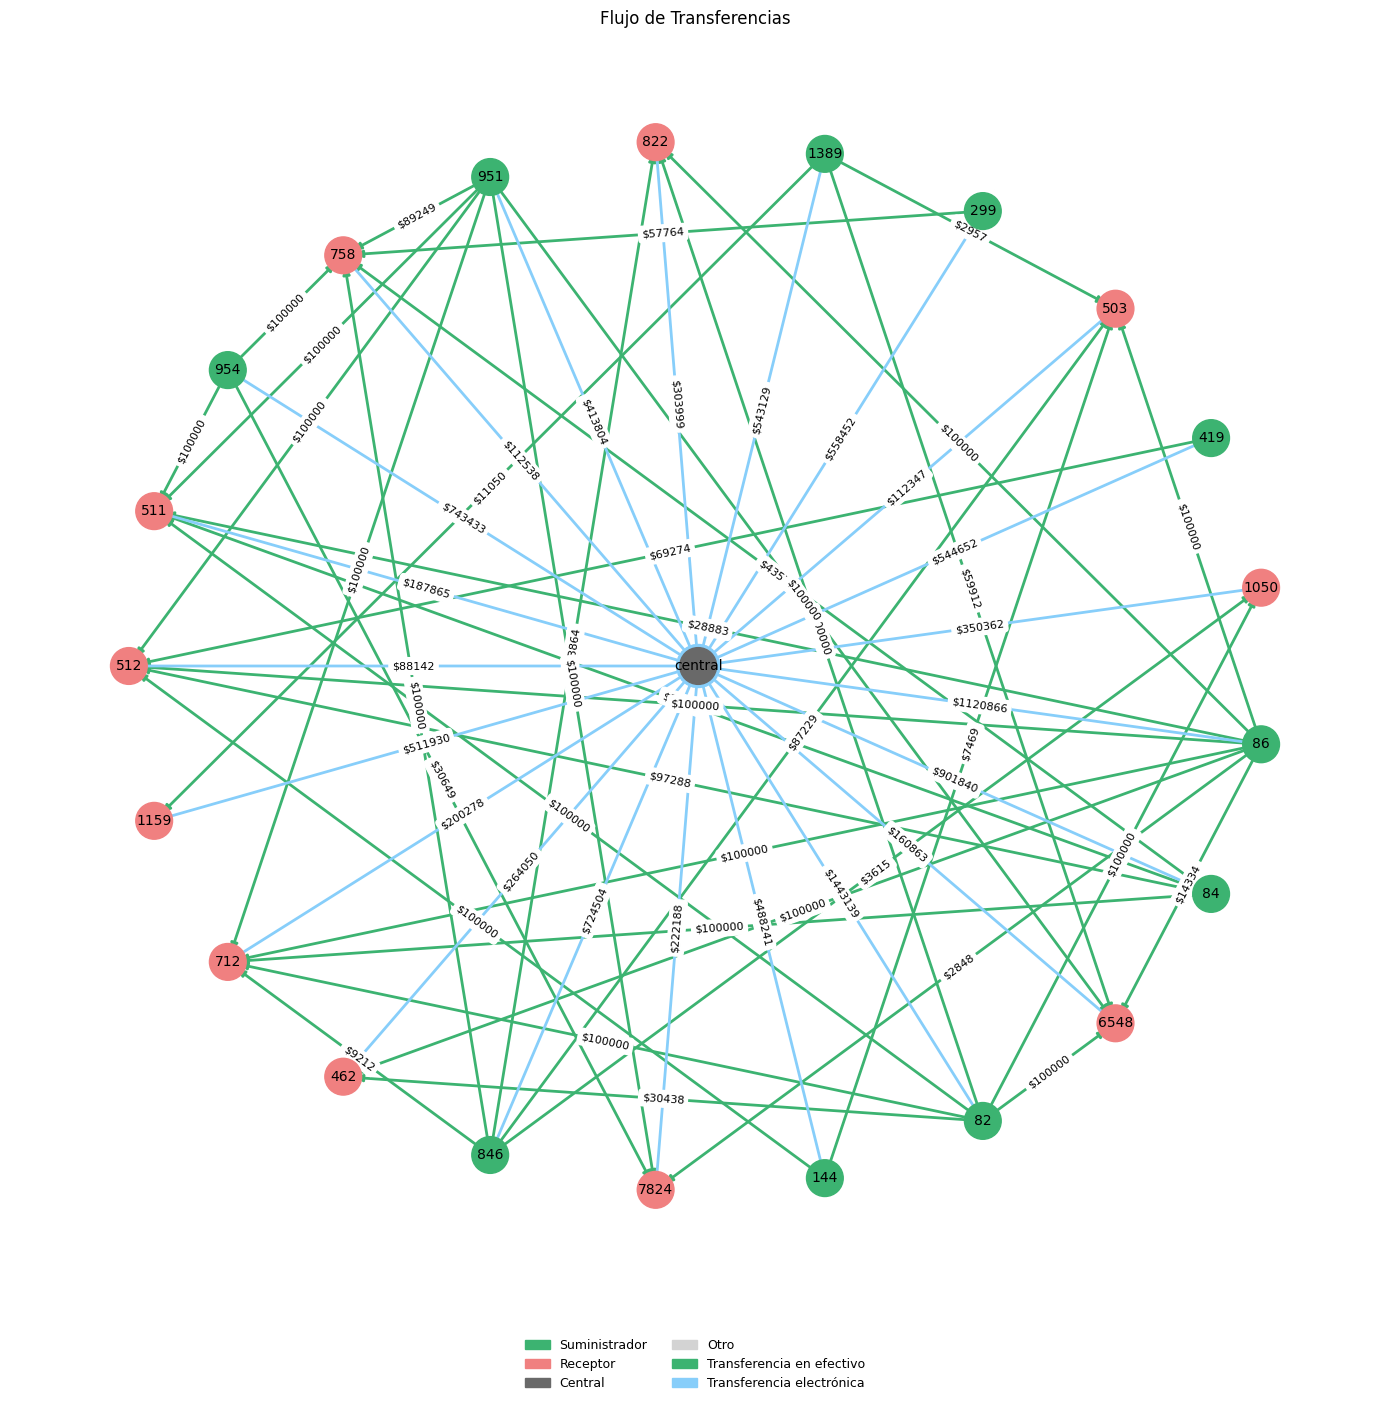

In [112]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Cargar transferencias
df_tiendas = pd.read_csv("transferencias_entre_tiendas.csv")
df_central = pd.read_csv("transferencias_a_central.csv")
df_total = pd.concat([df_tiendas, df_central], ignore_index=True)

# Crear grafo dirigido
G = nx.DiGraph()
for _, row in df_total.iterrows():
    G.add_edge(row['origen'], row['destino'], weight=row['monto_transferido'], tipo=row['tipo_envio'])

# Clasificar nodos
receptores = set(df_tiendas['destino'].unique())
suministradores = set(df_tiendas['origen'].unique())
nodos = list(G.nodes)

# Colores de nodos
colores_nodo = []
for n in nodos:
    if n == "central":
        colores_nodo.append("dimgray")
    elif n in receptores:
        colores_nodo.append("lightcoral")
    elif n in suministradores:
        colores_nodo.append("mediumseagreen")
    else:
        colores_nodo.append("lightgray")

# Posición: central en el centro (capa interna)
shells = [['central'], list(set(nodos) - {'central'})]
pos = nx.shell_layout(G, nlist=shells)

# Separar aristas por tipo
efectivo_edges = [(u, v) for u, v, d in G.edges(data=True) if d["tipo"] == "efectivo"]
electronico_edges = [(u, v) for u, v, d in G.edges(data=True) if d["tipo"] == "electrónico"]

# Dibujar grafo
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_color=colores_nodo, node_size=700)
nx.draw_networkx_labels(G, pos, font_size=10)

# Aristas
nx.draw_networkx_edges(G, pos, edgelist=efectivo_edges, edge_color="mediumseagreen", width=2, arrowstyle='-|>', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=electronico_edges, edge_color="lightskyblue", width=2, arrowstyle='-|>', arrows=True)

# Etiquetas de monto transferido
edge_labels = {(u, v): f"${d['weight']:.0f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Leyenda
legend_elements = [
    mpatches.Patch(color='mediumseagreen', label='Suministrador'),
    mpatches.Patch(color='lightcoral', label='Receptor'),
    mpatches.Patch(color='dimgray', label='Central'),
    mpatches.Patch(color='lightgray', label='Otro'),
    mpatches.FancyArrow(0, 0, 0.1, 0, color='mediumseagreen', label='Transferencia en efectivo'),
    mpatches.FancyArrow(0, 0, 0.1, 0, color='lightskyblue', label='Transferencia electrónica')
]

plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08),
           ncol=2, fontsize=9, frameon=False)

plt.title("Flujo de Transferencias", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()
